In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
require(MASS)
require(ISLR)

Loading required package: MASS
Loading required package: ISLR


In [4]:
%%R
auto.nn <- Auto
# Make origin a factor and remove the name predictor
auto.nn$origin2 <- ifelse(Auto$origin == 2, 1, 0)
auto.nn$origin3 <- ifelse(Auto$origin == 3, 1, 0)

auto.nn <- subset(auto.nn, select=-c(name, origin))

##Preamble

In [204]:
%%R
# Define useful functions
k.folds <- function(data, k=10){
    sample(1:k, nrow(data), replace=TRUE) 
}

k.folds.errs <- function(data, func, k=10, m=8, ...){
    folds <- k.folds(data=data, k=k)
    errs <- matrix(NA, k, m)
    for (i in 1:k){
#         Split into k folds
        train <- data[folds != i,]
        test <- data[folds == i,]
#         get errors for this k using any function that obeys this call signature and returns a vector of length m
        e <- func(train=train, test=test, m=m, ...)
        print(e)
        errs[i,] <- e
    }
#     Return a vector of the errors averaged over all k folds
    return(apply(errs, 2, mean))
}

##Subset Selection

In [212]:
%%R
subs.select <- function(X, train, test, m, ...){
    require(leaps)
    require(boot)
    response.var <- all.vars(X[[2]])
    regfit.full <- regsubsets(X, data=train, nvmax=m, ...)
    summary.reg <- summary(regfit.full)
#         Get the coef names minus intercept
    predictors <- regfit.full$xnames[-1]
    errs <- rep(NA, m)
    for (j in 1:m){
#             Get the list of predictors used in this subset (ignoring intercept)
        preds <- predictors[summary.reg$which[j, -1]]
#             Generate a linear formula for this model
        form <- as.formula(paste(response.var, paste(preds, collapse="+"), sep=" ~ "))
#             recreate the fit (because regsubsets doesn't actually make the fit)
        fit <- glm(form, data=train)
        pr <- predict(fit, newdata=test)
#             errs[i, j] is the mean squared error for the p=j predictor model, for fold i
        mse <- mean((pr - test)^2)
        print(mse)
        errs[j] <- mse
    } 
    return(errs)
}


Call:
glm(formula = form, data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-12.0519   -2.7605   -0.3468    2.1275   16.4400  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 46.4629684  0.8426837   55.14   <2e-16 ***
weight      -0.0077265  0.0002729  -28.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 19.1439)

    Null deviance: 22178.5  on 358  degrees of freedom
Residual deviance:  6834.4  on 357  degrees of freedom
AIC: 2082.6

Number of Fisher Scoring iterations: 2

[1] 1120028

Call:
glm(formula = form, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.8854  -2.3344  -0.1864   2.0043  14.2870  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.444e+01  4.245e+00  -3.401 0.000746 ***
weight      -6.730e-03  2.272e-04 -29.628  < 2e-16 ***
year         

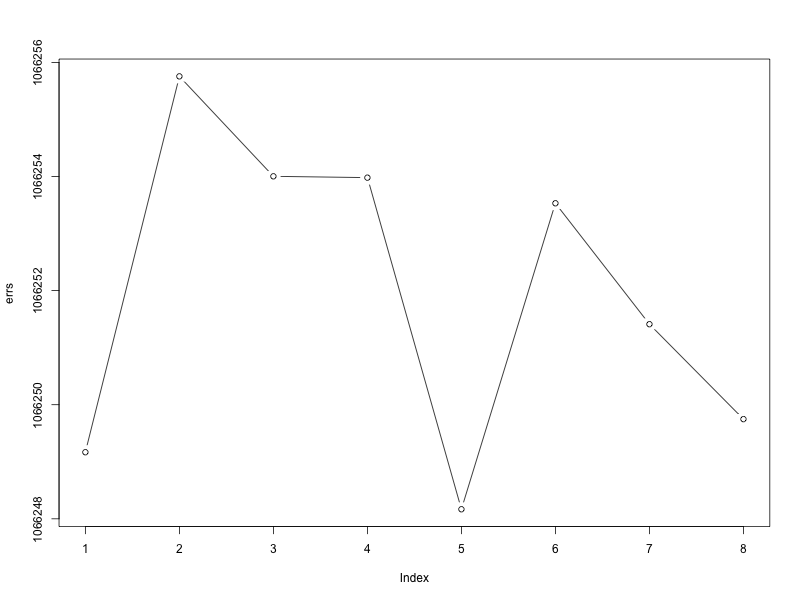

In [213]:
%%R -w 800 -h 600 -u px
# set.seed(1)
errs <- k.folds.errs(X=mpg~., data=auto.nn, func=subs.select)
# errs2 <- k.folds.errs(X=mpg~., data=auto.nn, func=subs.select, method='forward')
# errs3 <- k.folds.errs(X=mpg~., data=auto.nn, func=subs.select, method='backward')

dat <- matrix(c(errs, errs2, errs3), ncol=3, nrow=8)

plot(errs, type="b")
# matplot(dat,  type=c('b'), col=1:3, xlab="Subset size", ylab="Mean Squared Error", main="All Subsets")
# legend("topright", legend=1:3)

In [179]:
%%R
dat

        [,1]    [,2]    [,3]
[1,] 1059051 1050893 1058395
[2,] 1059073 1050908 1058404
[3,] 1059087 1050919 1058400
[4,] 1059068 1050914 1058400
[5,] 1059079 1050912 1058400
[6,] 1059066 1050916 1058400
[7,] 1059079 1050924 1058403
[8,] 1059076 1050915 1058398


In [119]:
%%R
reg.best <- regsubsets(mpg~., data=auto.nn)
coef(reg.best, 1)

 (Intercept)       weight 
46.216524549 -0.007647343 


It looks like the 'best' fit for this data is a single predictor model using weight.

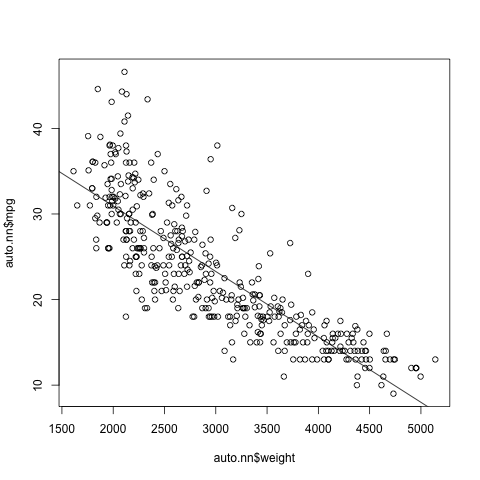

In [125]:
%%R
fit <- glm(mpg ~ weight, data=auto.nn)
plot(auto.nn$weight, auto.nn$mpg)
abline(fit)

##Ridge Regression and the Lasso

In [118]:
%%R


     [,1]
[1,]   20


In [33]:
%%R
library(boot)
cv.error <- rep(0, 8)
for (i in 1:8){
    glm.fit <- glm(mpg ~., data=auto.nn
}

[1] 11.38900 11.35042


In [125]:
%%R
fit <- lm(as.formula(paste('mpg', paste(c('cylinders', 'horsepower'), collapse="+"), sep=" ~ ")), data=auto.nn)
paste('mpg', paste(c('cylinders', 'horsepower'), collapse=" + "), sep=" ~ ")

[1] "mpg ~ cylinders + horsepower"


In [130]:
%%R
help(cv.glm)

R Help on ‘cv.glm’cv.glm                  package:boot                   R Documentation

_C_r_o_s_s-_v_a_l_i_d_a_t_i_o_n _f_o_r _G_e_n_e_r_a_l_i_z_e_d _L_i_n_e_a_r _M_o_d_e_l_s

_D_e_s_c_r_i_p_t_i_o_n:

     This function calculates the estimated K-fold cross-validation
     prediction error for generalized linear models.

_U_s_a_g_e:

     cv.glm(data, glmfit, cost, K)
     
_A_r_g_u_m_e_n_t_s:

    data: A matrix or data frame containing the data.  The rows should
          be cases and the columns correspond to variables, one of
          which is the response.

  glmfit: An object of class ‘"glm"’ containing the results of a
          generalized linear model fitted to ‘data’.

    cost: A function of two vector arguments specifying the cost
          function for the cross-validation.  The first argument to
          ‘cost’ should correspond to the observed responses and the
          second argument should corresp